# Typical results
-----------------
The results shown here are obtained from running simulations with the parameters given in the next section, and are
based mainly in the results shown in the [K-Athena repository](https://gitlab.com/pgrete/kathena/-/wikis/turbulence) and in [Federrath et al. (2010)](https://ui.adsabs.harvard.edu/abs/2011PhRvL.107k4504F/abstract).

### High level temporal evolution

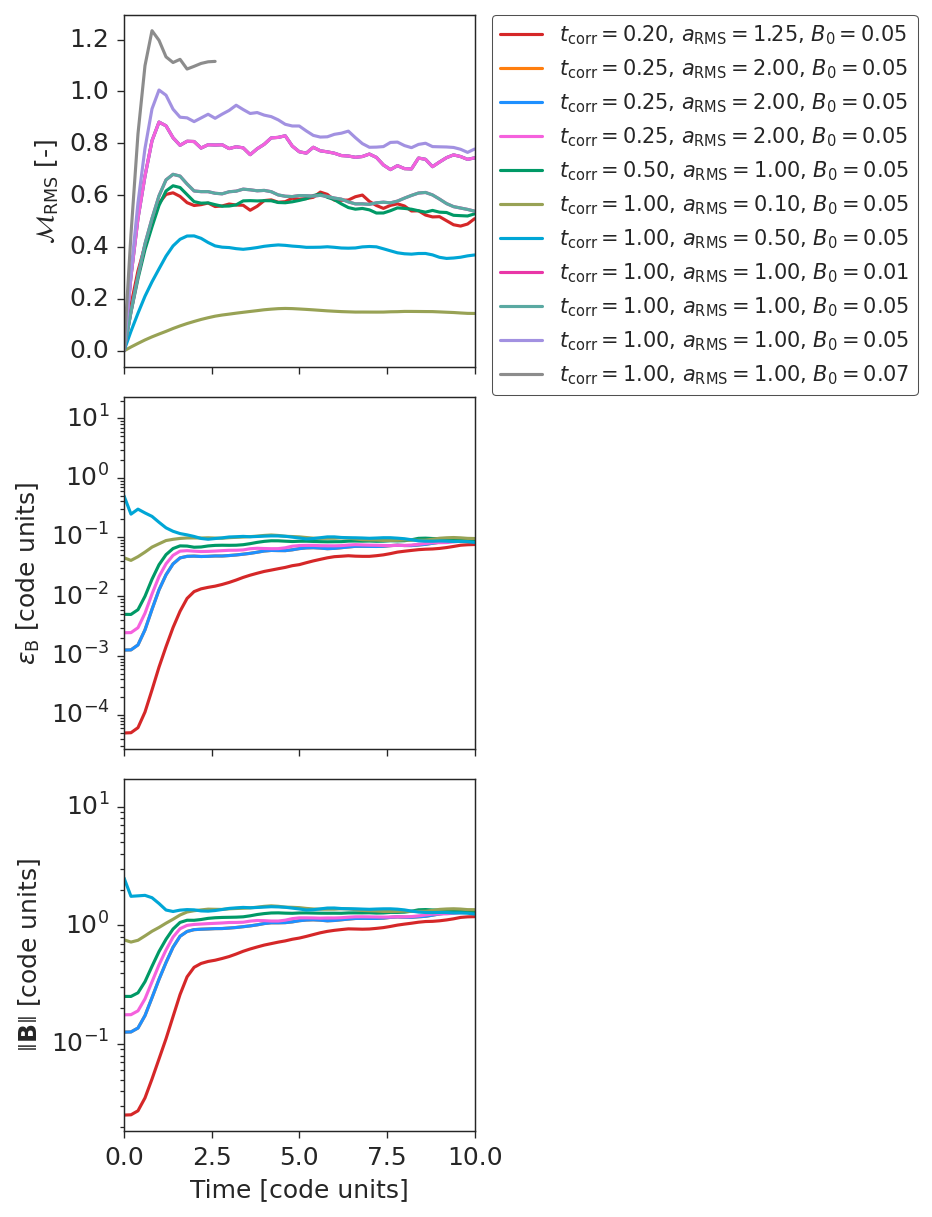

In [1]:
import os
import h5py
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from src.simclass_athenapk import SimAthenaPK
plt.style.use("/home/simonfch/astrochempy/plot_styles/modern.mplstyle")
sns.set_style("ticks")

output_path = "outputs"
fields_for_analysis = ["mach_number", "magnetic_energy_density", "magnetic_field_magnitude"]

runs = [run for run in os.listdir(output_path) if os.path.isdir(os.path.join(output_path, run))]
runs.sort()
legend_handles = []

fig, ax = plt.subplots(
    len(fields_for_analysis),
    1,
    dpi=150,
    figsize=(3, 8),
    sharex=True
)

for run in runs:
    if "NG_1-NC_256" in run:
        try:
            sim = SimAthenaPK(os.path.join(output_path, run))
            run_nc = sim.number_of_cells
            run_tcor = sim.correlation_time
            run_arms = sim.acceleration_field_rms
            run_Bini = sim.initial_magnetic_field

            try:
                with h5py.File(os.path.join(output_path, run, "analysis.h5"), "r") as file:
                    for f, field in enumerate(fields_for_analysis):
                        data = lambda x: file["average_values"][x][:]
                        if field == "mach_number":
                            # Plot in the first panel the `mach_number` field only for those
                            # runs with the same initial magnetic field equal to 0.05
                            if run_Bini == 0.05:
                                ax[f].plot(data("time"), data(field), label=run)
                        if field == "magnetic_energy_density" or field == "magnetic_field_magnitude":
                            # Plot in the second and third panels the `magnetic_energy_density`
                            # and `magnetic_field_magnitude` fields for runs with different initial
                            # magnetic field but same correlation time and acceleration field RMS
                            # equal to 1.0 and 1.0, respectively
                            if run_tcor == 1.0 and run_arms == 1.0:
                                ax[f].plot(data("time"), data(field), label=run)
                        else:
                            pass
            except FileNotFoundError or KeyError:
                print(f"WARNING: file `analysis.h5` not found in run `{run}` folder.")
                pass
            label  = fr'$t_{{\rm corr}}={run_tcor:0.2f}$, '
            label += fr'$a_{{\rm RMS}}={run_arms:0.2f}$, '
            label += fr'$B_0={run_Bini:0.2f}$'
            legend_handles.append(label)
        except AttributeError:
            pass

fig.tight_layout()
ax[0].set_xlim(0, 10)
ax[0].set_ylabel(r'$\mathcal{M}_{\rm RMS}$ [-]')
ax[1].set_ylabel(r'$\epsilon_{\rm B}$ [code units]')
ax[2].set_ylabel(r'$\left\| \mathbf{B} \right\|$ [code units]')
ax[-1].set_xlabel(r'Time [code units]')
ax[1].set_yscale("log")
ax[2].set_yscale("log")
ax[0].legend(
    legend_handles,
    loc="upper left",
    borderaxespad=0.,
    bbox_to_anchor=(1.05, 1)
)

### Convergence walltime test
Total walltime for each representative run

Found run NG_1-NC_064-TCOR_1.00-SOLW_1.00-ARMS_1.00-BINI_0.05-EOSG_1.00 with 064 cells
Found run NG_1-NC_128-TCOR_1.00-SOLW_1.00-ARMS_1.00-BINI_0.05-EOSG_1.00 with 128 cells
Found run NG_1-NC_256-TCOR_1.00-SOLW_1.00-ARMS_1.00-BINI_0.05-EOSG_1.00 with 256 cells
Found run NG_1-NC_512-TCOR_1.00-SOLW_1.00-ARMS_1.00-BINI_0.05-EOSG_1.00 with 512 cells


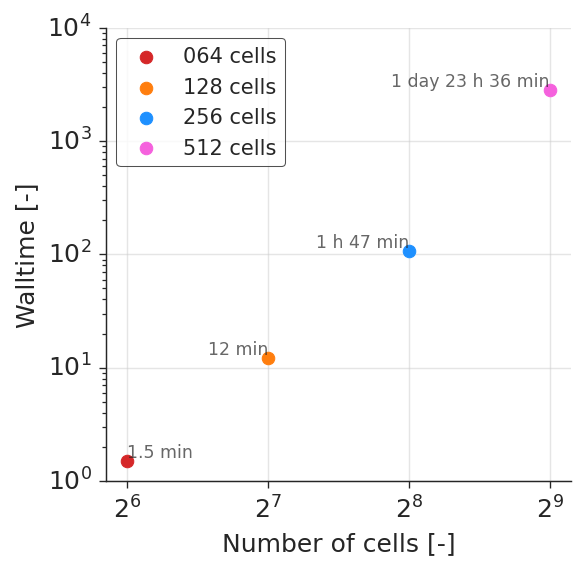

In [2]:
fig, ax = plt.subplots(1, 1, dpi=150, figsize=(4, 4))
walltime = ["1.5 min", "12 min", "1 h 47 min", "1 day 23 h 36 min"]
halignment = ["left", "right", "right", "right"]

i = 0
for run in runs:
    try:
        sim = SimAthenaPK(os.path.join(output_path, run))
        run_nc = str(sim.number_of_cells).zfill(3)

        if (
          "MFM_0" not in run
          and sim.correlation_time == 1.0
          and sim.acceleration_field_rms == 1.0
          and sim.initial_magnetic_field == 0.05
          and int(sim.input_attrs["problem/turbulence"][4][1]) == 4
        ):
            try:
                print("Found run {} with {} cells".format(run, run_nc))
                ax.scatter(int(run_nc), sim.walltime / 60, label=f"{run_nc} cells")

                ax.text(
                    int(run_nc),
                    sim.walltime / 60,
                    walltime[i],
                    horizontalalignment=halignment[i],
                    verticalalignment="bottom",
                    fontsize="small",
                    alpha=0.7
                )

                i += 1

            except Exception as e:
                raise Warning(f'Error loading snapshot {run} data: {str(e)}')

    except AttributeError:
        pass

ax.set_ylim(1e0, 1e4)
ax.set_ylabel("Walltime [-]")
ax.set_xlabel("Number of cells [-]")
ax.set_yscale("log")
ax.set_xscale("log", base=2)
ax.grid()
ax.legend()
sns.despine()
plt.savefig("outputs/walltime_vs_ncells.pdf", bbox_inches="tight")


### Velocity dispersion, sound speed velocity and Mach number calculations
The Mach number is calculated as the ratio of the RMS velocity to the sound speed, i.e.,
$$ \mathcal{M} = \frac{v_{\rm rms}}{c_{\rm s}}. $$
Here, the RMS velocity is calculated as:
$$ v_{\rm rms} = \sqrt{v_x^2 + v_y^2 + v_z^2}, $$
and the sound speed is calulated as:
$$ c_{\rm s} = \sqrt{\frac{\gamma P}{\rho}}, $$
with $\gamma$ the adiabatic index, $P$ the gas pressure, and $\rho$ the density.

Fortunately, most of these fields are already calculated by the `yt` module when you load a snapshot, as:
```python
ds = yt.load(snapshot_file_path)
ds.all_data()[('gas', 'mach_number')]
ds.all_data()[('gas', 'sound_speed')]
```
and below we can see that they are correctly calculated as if we've done it step by step.

In [3]:
import os
from src.simclass_athenapk import SimAthenaPK

# Usage example
run = 'NG_1-NC_256-TCOR_1.00-SOLW_1.00-ARMS_1.00-BINI_0.05-EOSG_1.00'
sim = SimAthenaPK(os.path.join('outputs', run))

ds = sim.__load_snapshot_data__(48)

def _pressure(field, data):
    return (
        (data.ds.gamma - 1.0)
        * data["gas", "density"]
        * data["gas", "specific_thermal_energy"]
    )

def _velocity_rms(field, data):
    return np.sqrt(
        data[("gas", "velocity_x")] ** 2 +
        data[("gas", "velocity_y")] ** 2 +
        data[("gas", "velocity_z")] ** 2
    )

ds.add_field(("gas", "pressure"), function=_pressure, sampling_type="local", units="dyne/cm*2")
ds.add_field(("gas", "velocity_rms"), function=_velocity_rms, sampling_type="local",  units="cm/s")

P = ds.all_data()[("gas", "pressure")]
rho = ds.all_data()[("gas", "density")]
v_rms = ds.all_data()[("gas", "velocity_rms")]

c_sound = np.sqrt(ds.gamma * P / rho)
mach_rms = v_rms / c_sound

results = [
    ["Pressure", P, "pressure"],
    ["Sound speed", c_sound, "sound_speed"],
    ["Mach number", mach_rms, "mach_number"]
]

for result in results:
    print(f">> {result[0]}:")
    print(f"   calculated  : {result[1]}")
    print(f"   yt built-in : {ds.all_data()[('gas', result[2])]}")


yt : [ERROR    ] 2024-01-22 22:38:14,642 Missing cosmological_simulation in parameter file definition!


>> Pressure:
   calculated  : [1.14011991 1.21493137 1.11785328 ... 1.0146271  1.0633893  1.0814631 ] dyn/cm**2
   yt built-in : [1.14011991 1.21493137 1.11785328 ... 1.0146271  1.0633893  1.0814631 ] dyn/cm**2
>> Sound speed:
   calculated  : [1.00015531 1.00017867 1.00019006 ... 1.00020272 1.00015921 1.0001731 ] sqrt(cm)*sqrt(dyn)/sqrt(g)
   yt built-in : [1.00015531 1.00017867 1.00019006 ... 1.00020272 1.00015921 1.0001731 ] cm/s
>> Mach number:
   calculated  : [0.39114226 0.28181    0.31028426 ... 0.20340438 0.26666249 0.40361046] sqrt(cm)*sqrt(g)/(sqrt(dyn)*s)
   yt built-in : [0.39114226 0.28181    0.31028426 ... 0.20340438 0.26666249 0.40361046] dimensionless


### Consistency of acceleration field


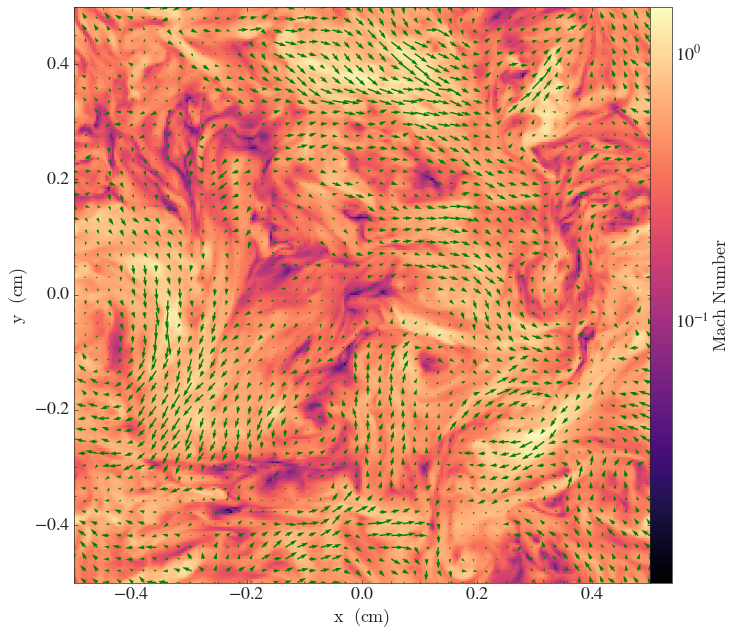

In [4]:
sim.plot_snapshot_field_map(48, ('gas', 'mach_number'), color_map='magma', overplot_velocity=True).show()

In [1]:
import os
from src.simclass_athenapk import SimAthenaPK

# Load an AthenaPK run
run = 'NG_1-NC_256-TCOR_1.00-SOLW_1.00-ARMS_1.00-BINI_0.05-EOSG_1.00'
sim = SimAthenaPK(os.path.join('outputs', run))

# Get snapshot's 48 magnetic energy
B = sim.get_snapshot_magnetic_energy(48)
print(f"Snapshot 48 magnetic energy:")
print(f"{B[0]}")
print(f"{B[1]}")

# # Print run available fields
# sim.get_run_available_fields()

yt : [ERROR    ] 2024-01-22 23:03:19,580 Missing cosmological_simulation in parameter file definition!


Snapshot 48 magnetic energy:
[0.10070474 0.00447747 0.10140925 ... 0.16753765 0.13285854 0.12623354] dyn/cm**2
[1007047.43768906   44774.73518138 1014092.51473069 ... 1675376.54653663
 1328585.43781354 1262335.42874245] G**2
